In [1]:
using Pkg
Pkg.add(;path="/Users/az/Documents/GitHub/GLOM_RV_Example")

   Updating git-repo `/Users/az/Documents/GitHub/GLOM_RV_Example`
   Updating registry at `~/.julia/registries/General`
  Resolving package versions...
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/Project.toml`
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/Manifest.toml`


In [2]:

Pkg.activate("examples")
Pkg.instantiate()

 Activating environment at `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Project.toml`


In [3]:
import Pkg; Pkg.add("CSV")

using Statistics

# for det()
using LinearAlgebra

# for importing the data from CSV
using DataFrames
using CSV


  Resolving package versions...
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Project.toml`
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Manifest.toml`


In [4]:
# For GLOM
# import Pkg; Pkg.add("GPLinearODEMaker")
import GPLinearODEMaker; GLOM = GPLinearODEMaker

GPLinearODEMaker

In [5]:
# For this module
using GLOM_RV_Example; GLOM_RV = GLOM_RV_Example

GLOM_RV_Example

In [6]:
# For units in orbit fitting functions
import Pkg; Pkg.add("Unitful")
using UnitfulAstro, Unitful

  Resolving package versions...
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Project.toml`
No Changes to `~/Documents/GitHub/GLOM_RV_Example/examples/examples/Manifest.toml`


In [7]:

## Problem setup

# CHANGE: choose a kernel, I suggest 3 for Matern 5/2 or 4 for Quasi-periodic
# kernel
kernel_choice = 4
kernel_names = ["pp", "se", "m52", "qp", "m52_m52", "se_se"]
kernel_name = kernel_names[kernel_choice]
kernel_function, num_kernel_hyperparameters = GLOM.include_kernel(kernel_name)

(GPLinearODEMaker.qp_kernel, 3)

In [8]:
# CHANGE: the stars rotation rate which is used as the first guess for some GLOM
# hyperparameters and starting point for priors
star_rot_rate = 27.  # days for solar rotation
last = 100

# CHANGE: observation times go here
using DelimitedFiles
obs_xs = collect(Iterators.flatten(readdlm("./data/bjd_daily.txt")))[1:last]
# taking out the mean observation times makes the optimization easier for models
# with periodic parameters
GLOM_RV.remove_mean!(obs_xs)

100-element Array{Float64,1}:
 -94.0826835292828
 -93.08372810534638
 -92.08427081042464
 -91.08734937909321
 -90.08436831641302
 -89.08671614898776
 -88.08030606357352
 -87.1391856148548
 -85.07661038349761
 -75.07995068086893
 -74.09923327293654
 -73.1019451257016
 -72.05461601664138
   ⋮
  86.9183723042297
  90.89301300501393
  91.89041234012984
  96.91769183589349
 100.89068160001625
 101.88447341258143
 102.91082533841836
 103.8837681139994
 105.88832158272999
 106.91145564196631
 107.88312550192495
 108.88539447698713

In [9]:
# CHANGE: rvs and their errors go here
obs_rvs = collect(Iterators.flatten(readdlm("./data/rv_daily.txt")))[1:last]
# inject_ks = GLOM_RV.kep_signal(; K=50u"m/s", P=sqrt(2)*5u"d", M0=rand()*2*π, ω_or_k=rand()*2*π, e_or_h=0.1)
# obs_rvs[:] .+= ustrip.(inject_ks.(obs_xs.*u"d"))
obs_rvs_err = collect(Iterators.flatten(readdlm("./data/erv_daily.txt")))[1:last]

100-element Array{Float64,1}:
 0.03036812271298431
 0.028174782382301478
 0.02938168070678178
 0.030733648918260983
 0.030273630749804166
 0.02978809045216476
 0.03479668670704809
 0.05661399795951553
 0.049404085779396215
 0.02941258553740282
 0.07400877379839974
 0.05641940799521519
 0.05493576014838747
 ⋮
 0.14691235315354487
 0.05307828537878864
 0.042584554070920794
 0.06901435317592487
 0.05777880997525311
 0.05303811006842724
 0.05770075708886935
 0.04175327852466612
 0.04090507117229551
 0.05895118403438244
 0.040303889806123705
 0.03944750090751184

In [10]:
# CHANGE: activity indicators and thier errors go here
# you can actually have as many as you want, but obviously it will take longer
# to fit
obs_indicator1 = collect(Iterators.flatten(readdlm("./data/C1.txt")))[1:last]
obs_indicator1_err = collect(Iterators.flatten(readdlm("./data/err_C1.txt")))[1:last]
obs_indicator2 = collect(Iterators.flatten(readdlm("./data/C2.txt")))[1:last]
obs_indicator2_err = collect(Iterators.flatten(readdlm("./data/err_C2.txt")))[1:last]


100-element Array{Float64,1}:
  5.756971312004282
  5.3652157914954595
  5.654645807928711
  5.925730235674198
  5.825554595635701
  5.887501707941508
  6.627535360942655
 10.619782436423465
  9.48548099736605
  5.536845159896076
 13.636395158606499
 10.394849664742399
 10.086845919158254
  ⋮
 26.693044848802298
  9.892413073405644
  7.813029822015975
 12.731825673176225
 10.461033634526089
  9.842709673431468
 10.667208707539606
  7.744231382374497
  7.552010979571698
 10.58257459843627
  7.519403961091692
  7.233208313151117

In [11]:
# removing means as the GP model assumes zero mean
GLOM_RV.remove_mean!(obs_rvs)
GLOM_RV.remove_mean!(obs_indicator1)
GLOM_RV.remove_mean!(obs_indicator2)

100-element Array{Float64,1}:
  11.356363769515074
  18.369840882498668
  44.91653127212058
  32.12358939834826
  36.39076877769131
  26.73560618205582
  18.2190949910584
  13.588531603166306
  28.442060247312018
   8.399795401432204
  13.826736907087298
  16.945512031813177
  19.422727582445024
   ⋮
 -26.205247165443875
   0.5709376372474573
  -6.09410561647665
  24.37227136655505
  21.860624281480288
  -1.5398256067648468
  12.081312289070784
  14.362266371876192
   9.31883822574854
   3.3698728914795772
  -5.638480496250157
 -10.254162252573682

In [12]:
# CHANGE: change these lines if you add more than 2 indicators
# this takes the data and riffles it together so it takes the form
# [rv_1, ind1_1, ind2_1, rv_2, ind1_2, ind2_2, ...]
n_out = 3  # number of indicators + 1
obs_ys = collect(Iterators.flatten(zip(obs_rvs, obs_indicator1, obs_indicator2)))
obs_noise = collect(Iterators.flatten(zip(obs_rvs_err, obs_indicator1_err, obs_indicator2_err)))


300-element Array{Float64,1}:
  0.03036812271298431
  7.86437518965105
  5.756971312004282
  0.028174782382301478
  8.077654743316922
  5.3652157914954595
  0.02938168070678178
  7.700195206719579
  5.654645807928711
  0.030733648918260983
  7.8474301601074075
  5.925730235674198
  0.030273630749804166
  ⋮
  0.04090507117229551
 11.675368595519458
  7.552010979571698
  0.05895118403438244
 18.109730207587884
 10.58257459843627
  0.040303889806123705
 12.077619273006398
  7.519403961091692
  0.03944750090751184
 11.219388489133108
  7.233208313151117

In [23]:
# How many differention orders we want in the GLOM model
n_dif = 2 + 1

3

In [24]:
# CHANGE: consider changing a0 (the GLOM coefficients that are used, see
# commented lines below)
# If all a's active:
problem_definition = GLOM.GLO(kernel_function, num_kernel_hyperparameters, n_dif, n_out, obs_xs, copy(obs_ys); noise=copy(obs_noise), a0=[[1. 1 1];[1 1 1];[1 1 1]])
# problem_definition = GLOM.GLO(kernel_function, num_kernel_hyperparameters, n_dif, n_out, obs_xs, copy(obs_ys); noise=copy(obs_noise), a0=[[1. 1 0];[1 0 1];[1 0 1]])

# Makes the std of each output equal to 1, improves fitting stability
# the normalizations are stored in problem_definition.normals
GLOM.normalize_problem_definition!(problem_definition)

In [25]:
# CHANGE: Setting initial fit values
initial_total_hyperparameters = collect(Iterators.flatten(problem_definition.a0))
initial_hypers = [[star_rot_rate], [star_rot_rate], [star_rot_rate], [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate, 2 * star_rot_rate, 1]]
append!(initial_total_hyperparameters, initial_hypers[kernel_choice])

12-element Array{Float64,1}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 27.0
 54.0
  1.0

In [26]:
## Fitting GLOM Model

# CHANGE: Setting kernel hyperparameter priors and kick function
# kick functions help avoid saddle points
tighten_lengthscale_priors = 3
if kernel_name in ["pp", "se", "m52"]
    kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) =
        GLOM_RV.kernel_hyper_priors_1λ(hps, d, star_rot_rate, star_rot_rate / 2 / tighten_lengthscale_priors)
    add_kick!(hps::Vector{<:Real}) = GLOM_RV.add_kick_1λ!(hps)
elseif kernel_name == "qp"
    kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) =
        GLOM_RV.kernel_hyper_priors_qp(hps, d, [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate / 2, star_rot_rate / 2, 0.4] ./ tighten_lengthscale_priors)
    add_kick!(hps::Vector{<:Real}) = GLOM_RV.add_kick_qp!(hps)
elseif kernel_name in ["se_se", "m52_m52"]
    kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) =
        GLOM_RV.kernel_hyper_priors_2λ(hps, d, [star_rot_rate, 2 * star_rot_rate, 1], [star_rot_rate / 2, star_rot_rate / 2, 1] ./ tighten_lengthscale_priors)
    add_kick!(hps::Vector{<:Real}) = GLOM_RV.add_kick_2λ!(hps)
else
    # kernel_hyper_priors(hps::Vector{<:Real}, d::Integer) = custom function
end




add_kick! (generic function with 1 method)

In [27]:
fit1_total_hyperparameters, result = GLOM_RV.fit_GLOM(problem_definition, initial_total_hyperparameters, kernel_hyper_priors, add_kick!)
# fit_GLOM returns a vector of num_kernel_hyperparameters gp hyperparameters
# followed by the GLOM coefficients and the Optim result object
workspace = GLOM.nlogL_matrix_workspace(problem_definition, fit1_total_hyperparameters)

gridsearching over hp10
starting at hp = 27.0 -> 11435.114956686824
searching from 20.25 to 33.75
ending at hp   = 27.0 -> 11435.114956686824
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 27.0, 54.0, 1.0]

[1.0256367661303054, 0.4585555595694317, 0.8697337551343552, 1.0967254125336208, 0.9335960894060464, 0.9682410180646835, 1.449757010502736, 1.0974306962509672, 1.0394853003961932, 27.006989719600274, 53.98448463705323, 1.6788333245378935]

Iteration:              1
Time so far:            16.646902799606323 s
Unnormalized posterior: 5402.846548060265
Gradient norm:          3898.3445910886817

[1.1748224612206215, 0.27607507835404177, 0.842648062408515, 1.1971484443307165, 0.9972712590178643, 0.9860801826874863, 1.5401714018563673, 0.9396171893466456, 0.9959941981520783, 28.97828295012866, 53.968953010078216, 1.768520257852047]

Iteration:              2
Time so far:            19.03348183631897 s
Unnormalized posterior: 5402.846548060265
Gradient norm:          3898.3445910886817

[

Iteration:              4
Time so far:            69.45798802375793 s
Unnormalized posterior: 714.124580933097
Gradient norm:          0.006179320407646571

[1.2658110724719271, -1.8978148214822887, -0.7733847670075178, 10.742928358325115, 1.574689694216521, 5.222394944691651, 4.189594057761794, -1.7430301277399747, 2.972827218266272, 28.754878739537304, 45.86715640740992, 2.5406392617337756]

Iteration:              5
Time so far:            87.40518403053284 s
Unnormalized posterior: 714.1245802935335
Gradient norm:          2.940525760664059e-6

[1.265811139457058, -1.8978149243996456, -0.7733848108126623, 10.742928983153359, 1.5746897717644475, 5.2223952389780575, 4.189594393133427, -1.74303019614004, 2.9728274339221916, 28.754878738661006, 45.86715678071614, 2.5406392436849607]

Iteration:              6
Time so far:            90.12523889541626 s
Unnormalized posterior: 714.1245802935335
Gradient norm:          2.940525760664059e-6


Iteration:              7
Time so far:        

GPLinearODEMaker.nlogL_matrix_workspace{Float64}([1.2658110774213451, -1.8978148292690014, -0.7733847701266113, 10.74292836416787, 1.5746896933196781, 5.222394945173858, 4.189594065196668, -1.7430301255289529, 2.972827218731227, 28.754878739269806, 45.867156405261014, 2.540639266924526], Cholesky{Float64,Array{Float64,2}}([6.2631948387965215 0.6003209606504848 … -4.407011555144251e-5 -0.0001227874379396155; 3.759927142367486 1.7014683548359235 … 8.019942289580782e-5 0.00010279899586746977; … ; -0.00027601972026696105 0.00011000056602950078 … 0.21814099787579952 0.012981919086101504; -0.000769041647572448 0.00010119736567768694 … 3.7741610062437134 0.3193228946568514], 'U', 0), [1.2658110774213451, -1.8978148292690014, -0.7733847701266113, 10.74292836416787, 1.5746896933196781, 5.222394945173858, 4.189594065196668, -1.7430301255289529, 2.972827218731227, 28.754878739269806, 45.867156405261014, 2.540639266924526], [[13.570847502386512 -14.15648833322519 … -0.11473029849413444 -0.05549547

In [28]:
## Plotting initial results

plot_xs = collect(LinRange(obs_xs[1]-10, obs_xs[end]+10, 300))
post, post_err, post_obs = GLOM_RV.GLOM_posteriors(problem_definition, plot_xs, fit1_total_hyperparameters)
GLOM_rvs_at_plot_xs, GLOM_ind1_at_plot_xs, GLOM_ind2_at_plot_xs = post
GLOM_rvs_err_at_plot_xs, GLOM_ind1_err_at_plot_xs, GLOM_ind2_err_at_plot_xs = post_err
GLOM_rvs_at_obs_xs, GLOM_ind1_at_obs_xs, GLOM_ind2_at_obs_xs = post_obs

Array dimensions do not match. The matrix can't be symmetric


3-element Array{Array{Float64,1},1}:
 [1.6650089665893162, 2.2089328737856304, 2.522684731794105, 3.126962057742458, 3.916826905547538, 2.3836956787652666, 1.821648038149744, 1.7779949248299898, 2.2460088697375147, -0.7835082121651472  …  -0.7436595790526471, 0.4628705260318274, 0.15323357711358934, 0.9924232690965072, 1.1564151722391762, 0.15996409537314002, -2.1997578128412756, -4.173008621949986, -2.6392126001286833, -1.5876679096442352]
 [-2.453114148403852, 11.717855440526998, 3.1645128823228768, -15.383808959550114, -24.752824971138327, -37.96022210948706, -58.29414126213357, -63.65293569504828, -99.56968277353016, -25.98335870838448  …  21.26790645251691, 37.52480624468833, 55.78531493086479, 42.031979638469934, 37.50206659092689, 32.260189070686735, 20.20736224563807, 32.87867868368736, 30.03845699181633, 61.59492150540862]
 [18.580026471987953, 16.045458125628862, 13.360008739877964, 14.229423686791735, 13.572276694744199, -2.769263571563103, -7.1318597676699165, -8.3191507543


starting rms:    1.735576649673091
no feat new rms: 0.01281964228021342


┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


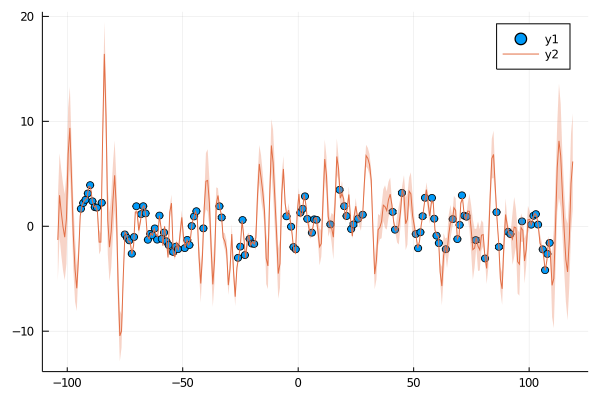

In [29]:
println("\nstarting rms:    ", std(obs_rvs))
println("no feat new rms: ", std(GLOM_rvs_at_obs_xs - obs_rvs))

using Plots
plt = scatter(obs_xs, obs_rvs, yerror=obs_rvs_err)
plot!(plt, plot_xs, GLOM_rvs_at_plot_xs, ribbons=GLOM_rvs_err_at_plot_xs, fillalpha=0.3)


In [ ]:
plt = scatter(obs_xs, obs_rvs, yerror=obs_rvs_err)
plot!(plt, plot_xs, GLOM_rvs_at_plot_xs, ribbons=GLOM_rvs_err_at_plot_xs, fillalpha=0.3)